# Data Mining Materials with pymatgen and matminer

## Step 1 - Introduction

Materials science is entering the data-driven era. With the rise of high-throughput density functional theory (DFT) calculations, massive datasets containing structural, electronic, and thermodynamic properties of materials are now publicly available. However, having big data is not enough — we need tools to:

1. Access this data programmatically.
2. Process, clean, and organize the data.
3. Extract useful features ("descriptors") that represent material properties.
4. Use these features for machine learning models and materials discovery.

In this tutorial, we will go beyond simple querying and learn how to search for new semiconducting materials that are similar to a known compound.

We will start from the material that has been used in previous tutorials, $\text{CaTiO}_3$, a perovskite oxide, and follow this process:

1. Choose a neighboring transition metal to substitute for Ti — we will take V.

2. Use band gap constraints to ensure the candidates are semiconductors.

3. Search for materials with similar composition using:

    - Pymatgen + Materials Project

    - Matminer datasets

4. Compare results and discuss possible applications.

## Step 2 - Setup and Installation

First, make sure you have the required libraries installed:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mp_api.client import MPRester
from matminer.datasets import load_dataset

/home/paladin/anaconda3/envs/matdata/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 3 - Defining the Search Parameters

Our base compound is $\text{CaTiO}_3$. Suppose we are investigating its properties because it shows promise for a specific application — say, as a **semiconducting material** for solar energy harvesting.

However, we might run into a few real-world constraints:

- Availability: Titanium may not be easily accessible or cost-effective in some regions.

- Performance: There might exist similar compounds with better electronic properties.

- Exploration: Sometimes, materials science is about looking for nearby alternatives that can surprise us.

To start our exploration, we’ll use a data-driven approach by querying the Materials Project database.

### Choosing a Neighboring Transition Metal

Looking at the Periodic Table, we notice that vanadium (V) sits right next to titanium (Ti) in the transition metals block.
Neighboring elements often share similar electronic configurations, so replacing Ti with V in $\text{CaTiO}_3$ could lead to structurally similar compounds — but with potentially different band gaps and properties.

Therefore, our new chemical system of interest is:

Calcium-Vanadium-Oxygen (Ca–V–O)

### Focusing on Semiconductors

Since we want to explore semiconductors for applications like photovoltaics, LEDs, or sensors, we’ll limit our search to materials with a band gap between $1.1$ and $3.2 \text{eV}$

This range covers typical semiconductors, excluding metals (small/no band gap) and insulators (very large band gap).

In summary, our search parameters are:

- Base compound: CaTiO₃

- Neighboring transition metal: V (Titanium neighbor).

- Band gap range: 1.1 – 3.2 eV (we want semiconductors).

- Chemically similar systems: Calcium-Vanadium oxides (Ca-V-O).

## Step 4 - Querying the Materials Project

### Connecting to the Materials Project

Just as we did in the previous tutorial, we need to connect to the Material Project to retrieve data by using our API key. For a detailed guide on how to obtain the key, please refer to the tutorial: [Querying Materials]((../querying/querying_materials.ipynb)).

```{important}
**Remember: you should not share your API key with anyone.**
```

We query the Materials Project database for Ca-V-O materials within the band gap range

In [2]:
# Replace YOUR_API_KEY_HERE with your Materials Project API key
API_KEY = "YOUR_API_KEY_HERE"
mpr = MPRester(API_KEY)

# Search parameters
bandgap_min = 1.1
bandgap_max = 3.2
chemsys = "Ca-V-O"  # Searching for CaVO3 and similar oxides

ValueError: Please use a new API key from https://materialsproject.org/api Keys for the new API are 32 characters, whereas keys for the legacy API are 16 characters.

In [18]:
# Query Materials Project for Ca-Zr-O semiconductors
results_mp = mpr.materials.summary.search(
    chemsys=chemsys,
    band_gap=(bandgap_min, bandgap_max),
    fields=["material_id", "formula_pretty", "band_gap",
            "formation_energy_per_atom", "density", "symmetry"]
)

df_mp = pd.DataFrame([
    {
        "material_id": r.material_id,
        "formula": r.formula_pretty,
        "band_gap": r.band_gap,
        "formation_energy_per_atom": r.formation_energy_per_atom,
        "density": r.density,
        "crystal_system": r.symmetry.crystal_system
    }
    for r in results_mp
])

# Sort by band gap for better readability
df_mp = df_mp.sort_values(by="band_gap").reset_index(drop=True)

df_mp

Retrieving SummaryDoc documents: 100%|██████████| 15/15 [00:00<00:00, 79638.68it/s]


,material_id,formula,band_gap,formation_energy_per_atom,density,crystal_system
0,mp-1048922,CaV2O4,1.1633,-2.709560,3.867841,Trigonal
1,mp-1041142,CaV2O4,1.2168,-2.736091,3.852460,Trigonal
2,mp-1365417,CaV2O4,1.3267,-2.684335,3.898550,Monoclinic
3,mp-1284741,Ca2V3O8,1.4963,-2.862569,3.822025,Monoclinic
4,mp-1342904,CaV2O6,1.5352,-2.567944,3.616555,Orthorhombic
5,mp-1835930,CaV2O4,1.5513,-2.788971,4.098466,Monoclinic
6,mp-1042856,Ca2V3O8,1.6592,-2.765350,3.571802,Hexagonal
7,mp-1663141,Ca2V3O8,1.9017,-2.777982,3.562255,Hexagonal
8,mp-1043217,CaV2O5,2.1831,-2.758699,3.054736,Orthorhombic
9,mp-891955,Ca10V6O25,2.3146,-2.990032,3.102293,Trigonal


## Step 5 - Exploring the Results

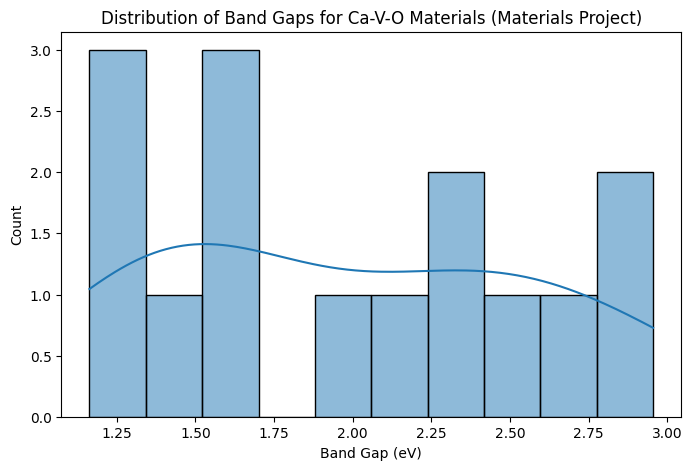

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df_mp["band_gap"], bins=10, kde=True)
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of Band Gaps for Ca-V-O Materials (Materials Project)")
plt.show()

## Step 6 - Using Matminer Datasets

The matminer library provides curated datasets ready for materials informatics. If you want to learn more about the datasets available in matminer, you can visit [their website here](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html). It is a very complete page that indicates the names and the content of the datasets, in addition the the number of entries of each dataset. This information will be essential when choosing which dataset might be useful for our wanted criteria. In our example, we are working with perovskites and a limited bandgap, so we will load matminer datasets that contain this information.